## Use this notebook to run inference on any image

In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import json
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
skeleton_data = [
        [0, 1], # right_ankle right_knee
        [1, 2], # right_knee right_hip
        [2, 6], # right_hip pelvis
        [6, 3], # pelvis left_hip
        [3, 4], # left_hip left_knee
        [4, 5], # left_knee left_ankle
        [12, 11], # right_shoulder right_elbow
        [11, 10], # right_elbow right_wrist
        [13, 14], # left_shoulder left_elbow
        [14, 15], # left_elbow left_wrist
        [2, 12], # right_hip right_shoulder
        [3, 13], # left_hip left_shoulder
        [2, 7], # right_hip right_thorax
        [3, 7], # left_hip thorax
        [12, 7], # right_shoulder thorax
        [13, 7], # left_shoulder thorax,
        [7, 8], # thorax upper_neck
        [8, 9], # upper_neck head_top
    ]

## Class Names and their label

In [3]:
class_names = {
 'sports': 0,
 'miscellaneous': 1,
 'home activities': 2,
 'occupation': 3,
 'fishing and hunting': 4,
 'home repair': 5,
 'conditioning exercise': 6,
 'lawn and garden': 7,
 'religious activities': 8,
 'music playing': 9,
 'inactivity quiet/light': 10,
 'water activities': 11,
 'running': 12,
 'winter activities': 13,
 'walking': 14,
 'dancing': 15,
 'bicycling': 16,
 'transportation': 17,
 'self care': 18,
 'volunteer activities': 19
}

In [4]:
image_height, image_width = 480, 640
image_height, image_width

(480, 640)

## Some processing functions

In [5]:
def open_file(path):
    valid_annot_data = None
    try:
        with open(path, 'r') as file:
            valid_annot_data = json.load(file)
        print(f"[+] Resized annotations resized successfully from {path}...")
        return valid_annot_data
    except Exception as e:
        print("[-] Failed to load the annotations")

In [7]:
def create_activity_wise_info(valid_annot_data, activity_wise_info):
    for i in range(len(valid_annot_data)):
        activity = valid_annot_data[i]['general_activity_name']
        image_name = valid_annot_data[i]['name']

        if activity not in activity_wise_info:
            activity_wise_info[activity] = []
            (activity_wise_info[activity]).append(image_name)
        else:
            (activity_wise_info[activity]).append(image_name)
    return

In [8]:
def rand_plot_activity(activity_wise_info, activity, dataset_path):
    choice = np.random.randint(low=0, high=len(activity_wise_info[activity]) - 1, size=1)[0]
    image_name = activity_wise_info[activity][choice]
    image = cv2.imread(f"{dataset_path}/images/{image_name}")

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'{activity}')
    plt.tight_layout()
    plt.show() 

In [9]:
valid_annot_data = open_file('../data/processed/resized_annotations_data.json')

[+] Resized annotations resized successfully from ../data/processed/resized_annotations_data.json...


In [10]:
activity_wise_info = dict()
activity_wise_info

{}

In [11]:
create_activity_wise_info(valid_annot_data, activity_wise_info)

In [12]:
len(activity_wise_info)

21

In [13]:
def rescale_image(image, target_size=(480, 640)):
  """
  Rescales an image and its annotations (bounding boxes and keypoints) to the target size.

  Args:
      image: Original image as a NumPy array.
  Returns:
      Rescaled image.
  """

  rescaled_image = cv2.resize(image, (target_size[1], target_size[0])) # (width, height)
  return rescaled_image

In [14]:
def draw_skeleton(skeleton_data, keypoints, image_height, image_width):
    # Drawing the skeleton
    poseHeatImage = np.zeros((image_height, image_width))
    for (jt1, jt2) in skeleton_data:
        for i in range(len(keypoints)):
            x1, y1 = int(keypoints[i][jt1][0]), int(keypoints[i][jt1][1])
            x2, y2 = int(keypoints[i][jt2][0]), int(keypoints[i][jt2][1])

            if (x1 == 0 and y1 == 0) or (x2 == 0 and y2 == 0): # Skip the joints whose keypoints are not predicted
                continue
            poseHeatImage = cv2.line(poseHeatImage, (x1, y1), (x2, y2), color=190, thickness=2) 

    # Placing the joints
    for i in range(len(keypoints)):
        for j in range(len(keypoints[i])):
            x, y = int(keypoints[i][j][0]), int(keypoints[i][j][1])
            poseHeatImage = cv2.circle(poseHeatImage, (x, y), radius=2, color=250, thickness=2)
    return poseHeatImage

## Specify the path to the models

In [15]:
keypoint_model_path = '../models/last.pt'
pose_class_model_path = '../models/pose_classification_13:14:15_18831.keras'

In [16]:
keypoint_model = YOLO(keypoint_model_path)
pose_classification_model = tf.keras.models.load_model(pose_class_model_path)

/opt/miniconda3/envs/aditya/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 496 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [17]:
def run_inference(keypoint_model, pose_classification_model, image_path, class_names):
    image = cv2.imread(image_path)
    rescaled_image = rescale_image(image, (image_height, image_width))

    # Estimate the keypoint locations using stage-1
    results = keypoint_model(rescaled_image)
    num_humans = results[0].keypoints.xy.shape[0]
    print(f"[+] Human_Count: {num_humans}")

    if results[0].keypoints.xy.shape[1] == 0:
        print(f"[-] Nothing detected, aborting....")
        return
    poseHeatImage = draw_skeleton(skeleton_data, results[0].keypoints.xy, image_height, image_width)
    poseHeatImage = poseHeatImage.reshape(image_height, image_width, 1)

    pose_data = np.concatenate([rescaled_image, poseHeatImage], axis=-1)
    pose_data = pose_data.astype(np.float32)
    pose_data = pose_data / 255.0
    channels = 4

    # Data to feed to the classification stage
    data_to_feed = pose_data.reshape(1, image_height, image_width, channels) # (1, 480, 640, 4)

    # Make the label predictions
    predictions = pose_classification_model.predict(data_to_feed)
    predictions = predictions[0]

    label = np.argmax(predictions)
    label_title = None

    for activity in class_names.keys():
        if class_names[activity] == label:
            label_title = activity
            break
    
    fig, axarr = plt.subplots(1, 2)
    axarr[0].imshow(cv2.cvtColor(rescaled_image, cv2.COLOR_BGR2RGB))
    axarr[1].imshow((poseHeatImage.astype(np.uint8)).reshape(image_height, image_width))
    fig.suptitle(label_title)
    plt.tight_layout()
    plt.show()

## Specify the relative path to the image on which you want to make predictions

In [27]:
image_path = 'download5.jpg' # only jpg and jpeg images are allowed, avif, webp are not allowed
image_path

'download5.jpg'

0: 480x640 1 human, 96.8ms
Speed: 4.0ms preprocess, 96.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
[+] Human_Count: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


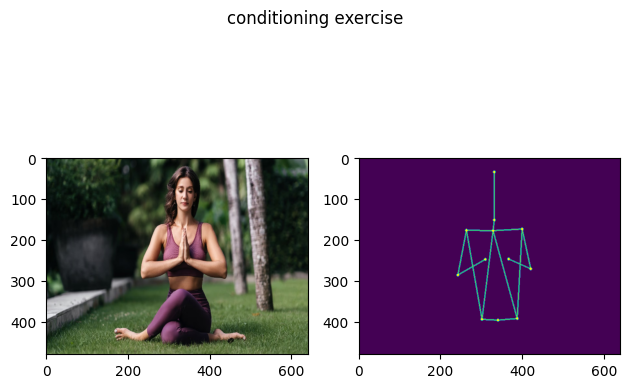

In [28]:
run_inference(keypoint_model, pose_classification_model, image_path, class_names)

## Use this visualise what of kind of data was present in a particular class in the original dataset

<h4>Helps to understand why the model is making wrong predictions</h4>

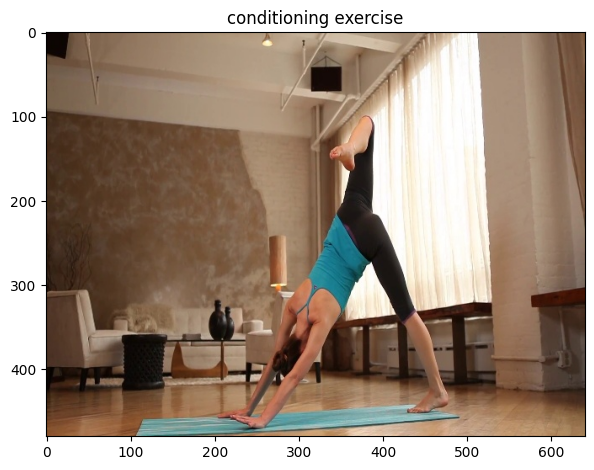

In [26]:
# This function is used visualise what kind of information does the given activity represent in the actual dataset, so that we can understand why
# model is classifying the iamges into particular activities
rand_plot_activity(activity_wise_info, 'conditioning exercise', '../data/processed')